Import the NumPy and Matplotlib modules:

In [18]:

try:
    import ipywidgets
except ImportError:
    import sys
    try:
        !{sys.executable} -m pip -q install ipywidgets
        import ipywidgets
    except ImportError:
        !{sys.executable} -m pip -q --user install ipywidgets
    finally:
        !jupyter nbextension enable --py widgetsnbextension
        print("You will need to refresh your browser page")
        
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


## Exercise 08.1 (function plotting)

Consider the function 
$$
f(x) = e^{x/10} \sin(\omega_{1}x)\sin(\omega_{0}x)
$$
from $x = -4\pi$ to $x = 4\pi$.

(1) Plot the function when $\omega_{0} = \omega_{1} = 1$. Label the axes.

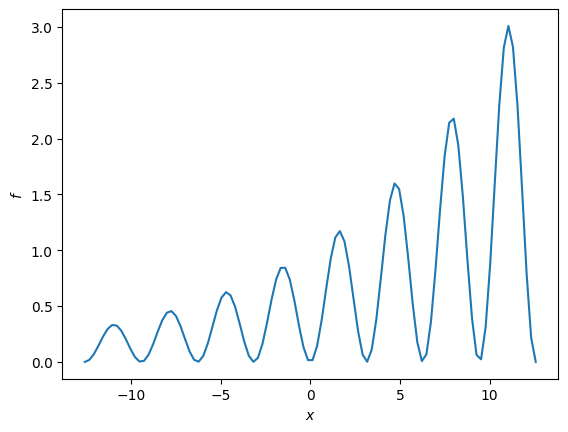

In [19]:


num_points = 100
x = np.linspace(-4 * np.pi, 4 * np.pi, num=num_points)

f = np.exp(x / 10) * np.sin(x) * np.sin(x)
plt.plot(x, f)
plt.xlabel('$x$')
plt.ylabel('$f$')
plt.show()

(2) Create an interactive plot with sliders for $\omega_{0}$ and $\omega_{1}$, varying from 0 to 2.

In [20]:
from ipywidgets import interact
from ipywidgets import interact, FloatSlider

def f_plot(omega0, omega1):
    x = np.linspace(-4*np.pi, 4*np.pi, 1000)
    f = np.exp(x/10)*np.sin(omega1*x)*np.sin(omega0*x)
    plt.figure(figsize=(8,4))
    plt.plot(x, f)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title(f"f(x) with ω0={omega0:.2f}, ω1={omega1:.2f}")
    plt.show()

interact(
    f_plot,
    omega0=FloatSlider(min=0,max=2,step=0.01,value=1),
    omega1=FloatSlider(min=0,max=2,step=0.01,value=1)
);

interactive(children=(FloatSlider(value=1.0, description='omega0', max=2.0, step=0.01), FloatSlider(value=1.0,…

## Exercise 08.2 (multiple function plotting)

Plot the function 

$$
f(x)  = \frac{\sin(x)}{x}
$$

from $x = -6\pi$ to $x = 6\pi$. Think carefully about which $x$ values you use when 
$x$ is close to zero.
  
Add to the above plot the graph of $1/ \left| x \right|$, and limit the range of the $y$ axis to 1 using
`plt.ylim`. (Hint: use `np.abs(x)` to return the absolute values of each 
component of a NumPy array `x`.)

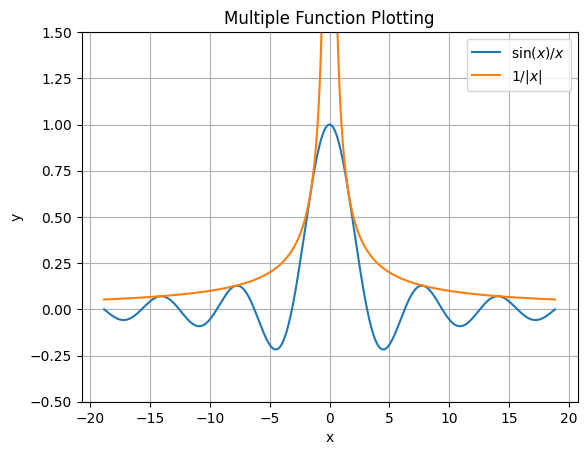

In [21]:
x = np.linspace(-6*np.pi, 6*np.pi, 4001)
x = x[x != 0]

f = np.sin(x) / x
g = 1 / np.abs(x)

plt.plot(x, f, label=r'$\sin(x)/x$')
plt.plot(x, g, label=r'$1/|x|$')

plt.ylim(-0.5, 1.5)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Multiple Function Plotting')
plt.legend()
plt.grid(True)
plt.show()


## Exercise 08.3 (demographics and interactive plotting)

A county planning body has requested an interactive tool to visualise the population distribution in Cambridgeshire (by district) from 2021 to 2031 for different population growth rate scenarios in each district. It can be assumed that:

- the growth rates are constant in each district;
- the annual growth rate in any one district shall be between -10% and 10%.

Building on the pie chart example with population data in the Activity notebook, create an interactive plot with:

1. A slider for the year (from 2021 to 2031); and
2. Sliders for the annual population growth for each district (in percentage), with an 
   initial value of zero for each district.

### Solution

There are number of ways this exercise could be done, from very simple but not very robust with respect to changes in the order of the input data, to quite techical but robust with repsect to the order in which data is entered.

In [22]:
# List of (district, population) data (in 2021)
from ipywidgets import interact

population_data = (('Cambridge City', 148500), 
                   ('East Cambridgeshire', 92630), 
                   ('Fenland', 107630), 
                   ('Huntingdonshire', 189440), 
                   ('South Cambridgeshire', 169800))

district = []
population = []

for i in range(len(population_data)):
    district.append(population_data[i][0])
    population.append(population_data[i][1])

colours = ['salmon', 'red', 'gold', 'green', 'lightblue']

def plot(year = 2021, r0 = 0, r1 = 1, r2 = 0, r3 = 0, r4 = 0):
    adjusted_population = np.array(population) * ((100 + np.array([r0, r1, r2, r3, r4]) / 100) ** (year - 2021))
    plt.pie(adjusted_population, labels = district, colors = colours, autopct = "%1.1f%%", shadow = True, startangle = 90)
    plt.show()

interact(plot, r0 = (-10, 10, 1), r1 = (-10, 10, 1), r2 = (-10, 10, 1), r3 = (-10, 10, 1), r4 = (-10, 10, 1), year = (2021, 2031, 1))



interactive(children=(IntSlider(value=2021, description='year', max=2031, min=2021), IntSlider(value=0, descri…

<function __main__.plot(year=2021, r0=0, r1=1, r2=0, r3=0, r4=0)>

## Exercise 08.4 (crime reports by location)

### Background

Your task is to produce a crime report data plot in the neighborhood of your college, by reported crime
category.

We can get crime data in the UK from the police data systems using what is known as a *REST API*,
and turn the data into a `list` of Python dictionaries. Each entry in the list is a police report 
(an entry is a Python dictionary detailing the report).

The first step is to import the modules we will be using:

In [29]:
!pip install requests

In [30]:
import json
import requests

The service https://data.police.uk has an interface where we can add specific strings to the URL (web address) to define what data we are intersted in, and the police server will return our requested data. The format is

    https://data.police.uk/api/crimes-street/all-crime?lat=52.629729&lng=-1.131592&date=2021-05
    
This return crimes reports within a one mile radius of the geographic coordinate point for the month `2021-05`.          

Below we create this URL string to include a part of the Cambridge city centre. You can modify this for your own college or other areas of interest (Google Maps is a handy way to get the geographic coordinates).

In [37]:
# A point in the Cambridge city centre (change this to your college)
lat, long = 52.205277, 0.119117

# year-month of interest
year_month = '2024-06'

# Construct request URL string
url = f"https://data.police.uk/api/crimes-street/all-crime?lat={lat}&lng={long}&date={year_month}"

# Fetch data from https://data.police.uk
r = requests.get(url)

# Check that data retrival was successful
r.raise_for_status()

The following converts the fetched data into a `list` of Python dictionaries:

In [38]:
crime_data = r.json()

To get an idea of how the data is arranged, we can look at the first report in the list. To make the displayed data easier to read, we use the 'pretty print' module `pprint`.

In [39]:
import pprint
if crime_data:
    pprint.pprint(crime_data[0])

{'category': 'anti-social-behaviour',
 'context': '',
 'id': 119514380,
 'location': {'latitude': '52.205330',
              'longitude': '0.123640',
              'street': {'id': 2039711, 'name': 'On or near Drummer Street'}},
 'location_subtype': '',
 'location_type': 'Force',
 'month': '2024-06',
 'outcome_status': None,
 'persistent_id': ''}


Each dictionary object corresponds to a reported crime.

### Task

Produce a bar chart of the number of reports in different categories. Run your program for different parts of Cambridge, starting with the area around your college, and for different months and years.

#### Hints

Create an empty dictionary, which will eventually map the report category to the number of incidents:

In [40]:
categories_freq = {}

Iterate over all reports in the list, and extract the category string from each report. If the category string (the 'key') is already in the dictionary increment the associated counter. Otherwise add the key to the dictionary, and associate the value 1.

In [41]:
# Iterate over all reports
for report in crime_data:
    # Get category type
    category = report['category']
    
    if category in categories_freq:
        # Increment counter here
        pass  # This can be removed once the 'if' block has a body
    else:
        # Add category to dictionary here
        pass  # This can be removed once the 'else' block has a body

The crime categories are the dictionary keys, which can be extracted using
```python
list(categories_freq.keys())
```

When adding the tick labels (crime categories), it may be necessary to rotate the labels, e.g.:
```python
plt.xticks(x_pos, categories, rotation='vertical')
```

### Extensions (optional)


1. Probe the retrieved data to build a set of all crime categories in the data set.
2. Explore the temporal (time) aspect of the data. Thinks of ways to represent the change in reported incident 
   types over time.
3. Explore what other data you can retrieve from https://data.police.uk/docs/.

### Solution

There are many ways this exercise could be programmed, and there is some choice in data structures.

Build (a) a list of crime categories and (b) the number of reports in each category:

In [43]:
# A point in the Cambridge city centre (change this to your college)
lat, long = 52.205277, 0.119117

# year-month of interest
year_month = '2025-06'

# Construct request URL string
url = f"https://data.police.uk/api/crimes-street/all-crime?lat={lat}&lng={long}&date={year_month}"

# Fetch data from https://data.police.uk
r = requests.get(url)

# Check that data retrival was successful
r.raise_for_status()

crime_data = r.json()



categories_freq = {}

for report in crime_data:
    category = report['category']

    if category in categories_freq:
        categories_freq[category] += 1
    else:
        categories_freq[category] = 1

Produce a bar chart:

<function matplotlib.pyplot.show(close=None, block=None)>

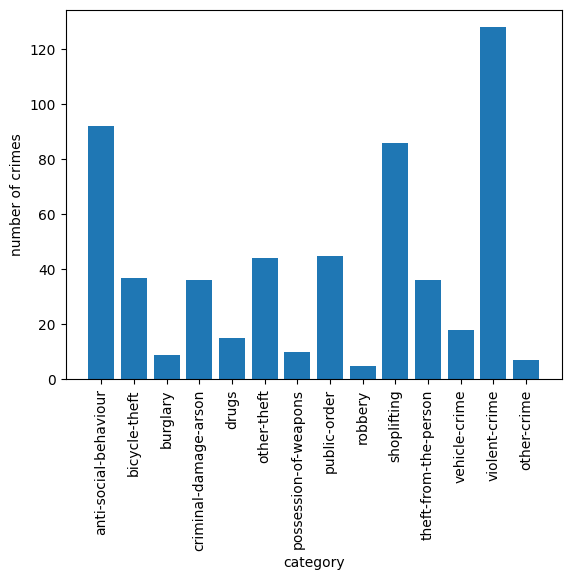

In [44]:
# Create an array with the position of each bar along the x-axis
x_pos = np.arange(len(categories_freq))

categories = list(categories_freq.keys())
counts = [categories_freq[cat] for cat in categories]

plt.bar(x_pos, counts, align = 'center')
plt.xticks(x_pos, categories, rotation = 90)

plt.xlabel('category')
plt.ylabel('number of crimes')

plt.show